In [2]:
import numpy as np
import os
import urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import ops as utils_ops
from pathlib import Path

%matplotlib inline

In [4]:
sys.path.append('../models/research/object_detection/')
from utils import label_map_util
from utils import visualization_utils as vis_util

# Download & load model

In [16]:
# Download
DATA_PATH = Path('model_data/')
MODEL_URL = 'ssd_mobilenet_v1_coco_2017_11_17.tar.gz'
MODEL_FILE = DATA_PATH / MODEL_URL
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

os.makedirs(DATA_PATH, exist_ok=True)
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_URL, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, DATA_PATH)

In [28]:
# Load model
PATH_TO_CKPT = DATA_PATH / 'ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(str(PATH_TO_CKPT), 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [32]:
# Load labels
PATH_TO_LABELS = os.path.join('../models/research/object_detection/data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Methods

In [52]:
def load_image_into_numpy_array(image):
    im_width, im_height = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

def show_npimg(x, figsize=None):
    if figsize: plt.figure(figsize=figsize)
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    
def process_image(x, show_original=True, show_result=True, figsize=None):
    image = Image.open(x)
    image_np = load_image_into_numpy_array(image)
    if show_original: show_npimg(image_np, figsize)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    output_dict = run_inference_for_single_image(image_np, detection_graph)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    
    if show_result: show_npimg(image_np, figsize)
    
    return image_np, output_dict

# Detection

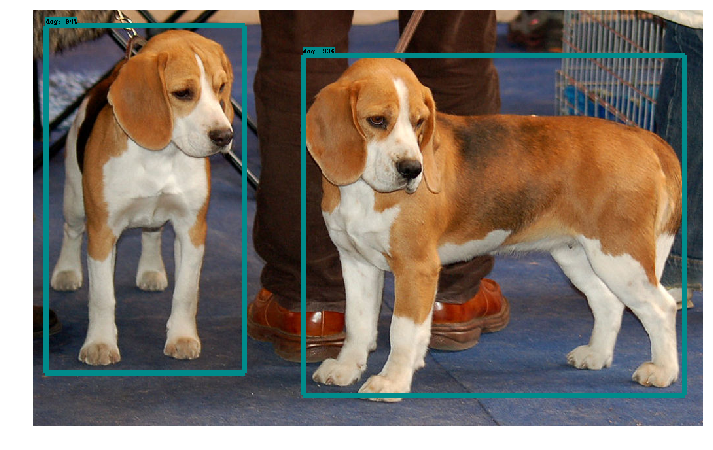

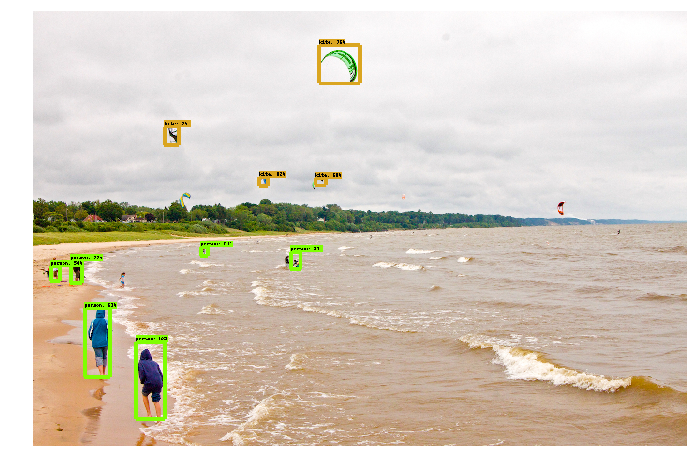

In [54]:
PATH_TO_TEST_IMAGES_DIR = '../models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, f'image{i}.jpg') for i in range(1, 3)]
IMAGE_SIZE = (12, 8) # Size, in inches, of the output images.

for image_path in TEST_IMAGE_PATHS:
    res_img, res_details = process_image(image_path, show_original=False, figsize=IMAGE_SIZE)

In [64]:
res_details.keys()

dict_keys(['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'])

In [66]:
res_details['detection_boxes'].shape, res_details['detection_boxes'][0]

((100, 4),
 array([0.5538768 , 0.3942238 , 0.5931247 , 0.40913767], dtype=float32))

In [77]:
res_details['detection_scores'][:5], res_details['detection_classes'][:5]

(array([0.91687846, 0.82944554, 0.7785057 , 0.7699842 , 0.75553864],
       dtype=float32), array([ 1, 38,  1, 38, 38], dtype=uint8))

In [80]:
[c for c in categories if c['id'] in res_details['detection_classes'][:5]]

[{'id': 1, 'name': 'person'}, {'id': 38, 'name': 'kite'}]